In [1]:
from pathlib import Path
import subprocess

REPO_URL = "https://github.com/seoultechpse/fenicsx-colab.git"
ROOT = Path("/content")
REPO_DIR = ROOT / "fenicsx-colab"

subprocess.run(
  ["git", "clone", REPO_URL, str(REPO_DIR)],
  check=True
)

USE_CLEAN = False  # <--- Set True to remove existing environment
opts = "--clean" if USE_CLEAN else ""

get_ipython().run_line_magic(
    "run", f"{REPO_DIR / 'setup_fenicsx.py'} {opts}"
)

⚠️ Google Drive not mounted — using local cache (/content)
🔧 Installing FEniCSx environment...
✨ Loading FEniCSx Jupyter magic... %%fenicsx registered


---

In [2]:
%%fenicsx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import basix
import basix.ufl

# Coefficients defining the polynomial space in terms of orthogonal polynomials on the cell
wcoeffs = np.eye(8, 9)

print(f"wcoeffs = \n{wcoeffs}")

geometry = basix.geometry(basix.CellType.quadrilateral)
topology = basix.topology(basix.CellType.quadrilateral)

print(f"\ngeometry = \n{geometry}")
print(f"\ntopology = \n{topology}")

# Points and weights used to define functionals on each sub-entity of the cell
x = [[], [], [], []]
M = [[], [], [], []]

# Associate one point evaluation with each vertex
for v in topology[0]:
    x[0].append(np.array(geometry[v]))
    M[0].append(np.ones([1, 1, 1, 1]))

# Associate an integral with each edge
pts, wts = basix.make_quadrature(basix.CellType.interval, 1)
for e in topology[1]:
    v0 = geometry[e[0]]
    v1 = geometry[e[1]]
    # Map points on the reference interval to each edge of the quadrilateral
    edge_pts = np.array([v0 + p * (v1 - v0) for p in pts])
    x[1].append(edge_pts)

    mat = np.zeros((1, 1, pts.shape[0], 1))
    mat[0, 0, :, 0] = wts
    M[1].append(mat)

# Associate 0 DOFs with the interior of the cell
x[2].append(np.zeros([0, 2]))
M[2].append(np.zeros([0, 1, 0, 1]))

tnt_degree1 = basix.ufl.custom_element(
    basix.CellType.quadrilateral, [], wcoeffs, x, M, 0,
    basix.MapType.identity, basix.SobolevSpace.H1, False, 1, 2)

# -------------------------------------------------------------
# Basis function visualization
# -------------------------------------------------------------
element = tnt_degree1._element  # Extract basix element

# Create grid for evaluation
n_points = 30
xi = np.linspace(0, 1, n_points)
eta = np.linspace(0, 1, n_points)
XI, ETA = np.meshgrid(xi, eta)
points = np.column_stack([XI.ravel(), ETA.ravel()])

# Evaluate basis functions at all points
basis_data = element.tabulate(0, points)
# shape: (derivative_order, evaluation_points, basis_functions, components) = (1, 900, 8, 1)

# 0th derivative (function values), all evaluation points, all basis functions, first component
basis_values = basis_data[0, :, :, 0]  # shape: (900, 8)
basis_values = basis_values.T  # shape: (8, 900)

num_basis = basis_values.shape[0]
num_eval_points = basis_values.shape[1]

print(f"\nNumber of basis functions: {num_basis}")
print(f"Number of evaluation points: {num_eval_points}")

# 3D surface plots of basis functions
n_cols = 4
n_rows = (num_basis + n_cols - 1) // n_cols

# Find global min and max for consistent colorbar
vmin = np.min(basis_values)
vmax = np.max(basis_values)

fig = plt.figure(figsize=(16, 3.6 * n_rows))

# Adjust subplot layout to leave space for colorbar at bottom
gs = fig.add_gridspec(n_rows, n_cols, hspace=0.0, wspace=0.3,
                      bottom=0.1, top=0.95)

for i in range(num_basis):
    row = i // n_cols
    col = i % n_cols
    ax = fig.add_subplot(gs[row, col], projection='3d')

    # Convert basis function values to grid format
    Z = basis_values[i, :].reshape(n_points, n_points)

    # Surface plot with consistent color scale
    surf = ax.plot_surface(XI, ETA, Z, cmap='viridis',
                          edgecolor='none', alpha=0.8,
                          vmin=vmin, vmax=vmax)

    # Axis labels
    ax.set_xlabel('ξ')
    ax.set_ylabel('η')
    ax.set_title(f'$φ_{i}$')

    # Set tick fontsize
    ax.tick_params(labelsize=8)

    ax.tick_params(axis='x', pad=-2)
    ax.tick_params(axis='y', pad=-2)
    ax.tick_params(axis='z', pad=0)

    # Adjust view angle
    ax.view_init(elev=25, azim=45)

# Add single colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])
fig.colorbar(surf, cax=cbar_ax, orientation='horizontal',
             label='Basis Function Value')

plt.savefig('basis_functions_3d.png', dpi=150, bbox_inches='tight')

# 2D contour plots
fig2 = plt.figure(figsize=(16, 3.8 * n_rows))

# Adjust subplot layout for colorbar
gs2 = fig2.add_gridspec(n_rows, n_cols, hspace=0.2, wspace=0.3,
                        bottom=0.1, top=0.95)

# Define explicit levels from 0 to 1
levels = np.linspace(-0.25, 1, 11)

for i in range(num_basis):
    row = i // n_cols
    col = i % n_cols
    ax = fig2.add_subplot(gs2[row, col])

    Z = basis_values[i, :].reshape(n_points, n_points)

    # Contour plot with consistent color scale
    contour = ax.contourf(XI, ETA, Z, levels=levels, cmap='viridis',
                         vmin=vmin, vmax=vmax)

    # Mark DOF locations
    if i < 4:  # Vertex DOFs
        ax.plot(geometry[i][0], geometry[i][1], 'ro',
                markersize=10, label='Vertex DOF', zorder=5)
        ax.legend()

    ax.set_xlabel('ξ')
    ax.set_ylabel('η')
    ax.set_title(f'$φ_{i}$')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Add single colorbar at the bottom
cbar_ax2 = fig2.add_axes([0.15, 0.02, 0.7, 0.02])
fig2.colorbar(contour, cax=cbar_ax2, orientation='horizontal',
              label='Basis Function Value')

plt.savefig('basis_functions_contour.png', dpi=150, bbox_inches='tight')

# Print DOF locations and types
print("\n=== DOF Information ===")
dof_idx = 0
for dim in range(3):
    if dim == 0:
        entity_name = "Vertex"
    elif dim == 1:
        entity_name = "Edge"
    elif dim == 2:
        entity_name = "Face"

    for entity_idx, points_list in enumerate(x[dim]):
        if len(points_list) > 0:
            print(f"\n{entity_name} {entity_idx}:")
            if dim == 0:  # Vertices
                print(f"  DOF {dof_idx}: location {points_list}")
                dof_idx += 1
            else:  # Edges or faces
                for pt in points_list:
                    print(f"  DOF {dof_idx}: location {pt}")
                    dof_idx += 1

print(f"\nTotal number of DOFs: {dof_idx}")

# -------------------------------------------------------------
# Compute actual polynomial representation of basis functions
# -------------------------------------------------------------
# Print detailed information about orthogonal polynomials used by Basix
print("\n=== Basix Orthogonal Polynomial Information ===")

# Get available element information
print(f"Cell type: {element.cell_type}")
print(f"Degree   : {element.degree}")
print(f"Family   : {element.family}")

print("\nBasix uses orthogonal polynomials on the reference element.")
print("\nFor a quadrilateral, these are typically tensor products of 1D orthogonal polynomials.")
print("The most common choice is Legendre polynomials.")

# The 1D Legendre polynomials on [0,1] are:
print("\n1D Legendre polynomials L_n(t) on [0,1]:")
print("L_0(t) = 1")
print("L_1(t) = 2t - 1")
print("L_2(t) = 6t² - 6t + 1")
print("L_3(t) = 20t³ - 30t² + 12t - 1")

print("\n=== Basis Functions in Explicit Form ===")
print("\nFor 2D quadrilateral, the basis is P_ij(ξ,η) = L_i(ξ) * L_j(η)")
print("φ_i(ξ,η) = Σ_j w_ij * P_j(ξ,η)\n")

print("\n=== Basis Functions as Polynomials ===")

try:
    from scipy.linalg import lstsq

    print("\nFitting basis functions as polynomials in standard monomial basis")
    print("General form: a + b*ξ + c*η + d*ξ*η + e*ξ² + f*η² + g*ξ²*η + h*ξ*η² + i*ξ²*η²\n")

    # Sample points for fitting
    n_sample = 100
    np.random.seed(42)
    sample_points = np.random.rand(n_sample, 2)

    # Evaluate basis functions at sample points
    basis_at_samples = element.tabulate(0, sample_points)[0, :, :, 0]  # shape: (n_sample, 8)

    # Create polynomial feature matrix (monomials up to degree 2)
    poly_features = np.column_stack([
        np.ones(n_sample),                              # 1
        sample_points[:, 0],                            # ξ
        sample_points[:, 1],                            # η
        sample_points[:, 0] * sample_points[:, 1],      # ξη
        sample_points[:, 0]**2,                         # ξ²
        sample_points[:, 1]**2,                         # η²
        sample_points[:, 0]**2 * sample_points[:, 1],   # ξ²η
        sample_points[:, 0] * sample_points[:, 1]**2,   # ξη²
        sample_points[:, 0]**2 * sample_points[:, 1]**2 # ξ²η²
    ])

    monomial_labels = ['1', 'ξ', 'η', 'ξη', 'ξ²', 'η²', 'ξ²η', 'ξη²', 'ξ²η²']

    for i in range(num_basis):
        result = lstsq(poly_features, basis_at_samples[:, i])
        coeffs = result[0]

        # Build polynomial expression
        terms = []
        for c, label in zip(coeffs, monomial_labels):
            if abs(c) > 1e-10:
                if label == '1':
                    terms.append(f"{c:.2f}")
                else:
                    sign = '+' if c >= 0 else '-'
                    terms.append(f"{sign}{abs(c):.2f}*{label}")

        # Format nicely
        expr_str = terms[0]
        for term in terms[1:]:
            expr_str += f" {term}"

        print(f"φ_{i}(ξ,η) = {expr_str}")

        # Verify at key points (vertices and center)
        test_points = np.array([
            [0.0, 0.0],  # vertex 0
            [1.0, 0.0],  # vertex 1
            [1.0, 1.0],  # vertex 2
            [0.0, 1.0],  # vertex 3
            [0.5, 0.5]   # center
        ])

        print("\n  Verification at key points:")
        max_error = 0.0
        for pt in test_points:
            actual = element.tabulate(0, pt.reshape(1, -1))[0, 0, i, 0]
            # Compute polynomial value
            computed = coeffs[0]  # constant
            computed += coeffs[1] * pt[0]  # ξ
            computed += coeffs[2] * pt[1]  # η
            computed += coeffs[3] * pt[0] * pt[1]  # ξη
            computed += coeffs[4] * pt[0]**2  # ξ²
            computed += coeffs[5] * pt[1]**2  # η²
            computed += coeffs[6] * pt[0]**2 * pt[1]  # ξ²η
            computed += coeffs[7] * pt[0] * pt[1]**2  # ξη²
            computed += coeffs[8] * pt[0]**2 * pt[1]**2  # ξ²η²

            error = abs(actual - computed)
            max_error = max(max_error, error)
            print(f"    ({pt[0]:.1f}, {pt[1]:.1f}): actual={actual:8.5f}, fitted={computed:8.5f}, error={error:.2e}")

        print(f"  Maximum error: {max_error:.2e}\n")

except ImportError:
    print("\nNote: Install scipy for polynomial fitting")
    print("  pip install scipy")

wcoeffs = 
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]

geometry = 
[[0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 1.]]

topology = 
[[[0], [1], [2], [3]], [[0, 1], [0, 2], [1, 3], [2, 3]], [[0, 1, 2, 3]]]

Number of basis functions: 8
Number of evaluation points: 900

=== DOF Information ===

Vertex 0:
  DOF 0: location [[0. 0.]]

Vertex 1:
  DOF 1: location [[1. 0.]]

Vertex 2:
  DOF 2: location [[0. 1.]]

Vertex 3:
  DOF 3: location [[1. 1.]]

Edge 0:
  DOF 4: location [0.5 0. ]

Edge 1:
  DOF 5: location [0.  0.5]

Edge 2:
  DOF 6: location [1.  0.5]

Edge 3:
  DOF 7: location [0.5 1. ]

Total number of DOFs: 8

=== Basix Orthogonal Polynomial Information ===
Cell type: CellType.quadrilateral
Degree   : 2
Family   : ElementFamily.custom

Basix uses orthogonal polynomials on the reference element.

For a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

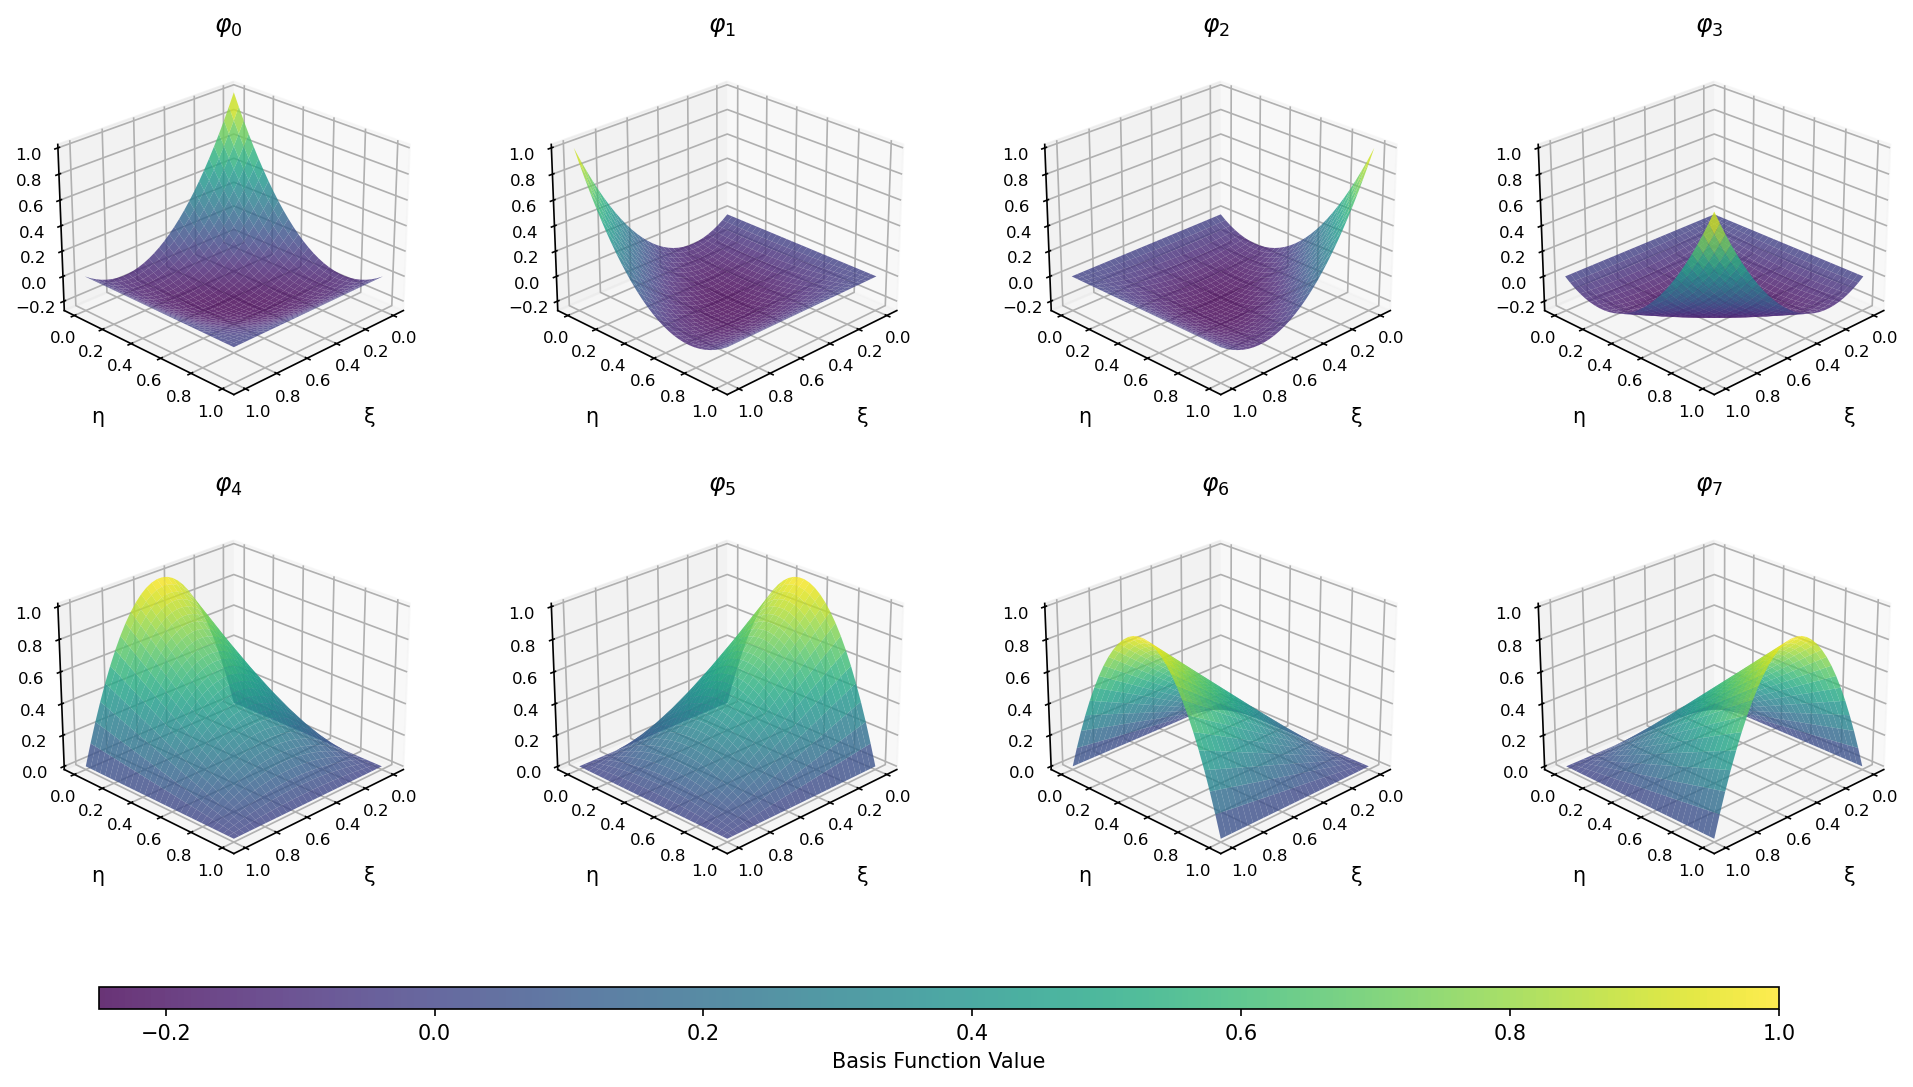

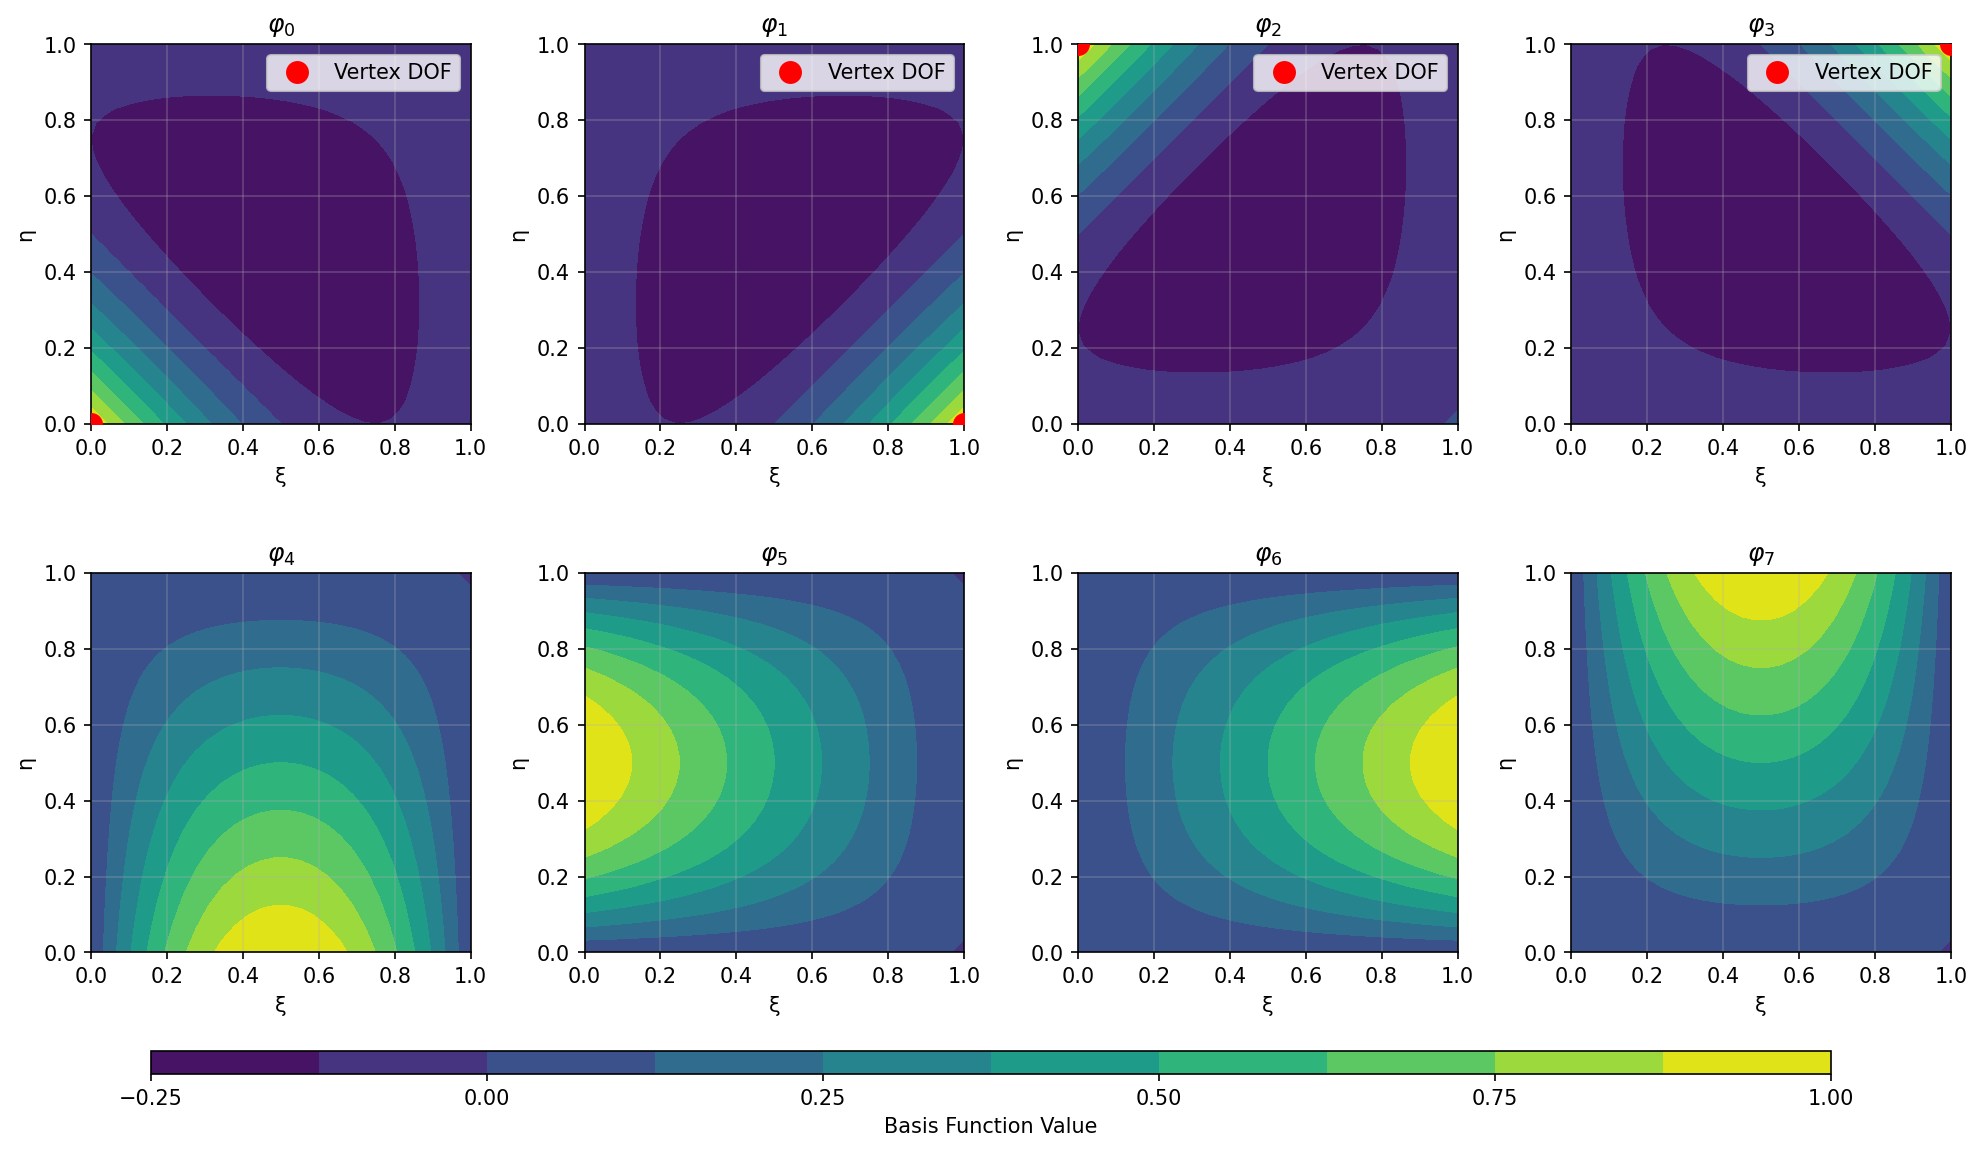

In [3]:
from google.colab import files
files.download('basis_functions_3d.png')
files.download('basis_functions_contour.png')

from IPython.display import Image, display

display(Image(filename='basis_functions_3d.png'))

print()

display(Image(filename='basis_functions_contour.png'))